In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [20]:
# Build a network that responds to orientation/spatial frequency input
# Units that have similar tuning preferences are near each other

# Start by initializing a network of 'neurons'
# Each unit has a spatial frequency and orientation tuning preference, dictated by its location in the grid
# We will specify 50 levels of orientation and spatial frequency preferences, for a grid of 2500 possible combinations

levels = 50

# We will also specify some other inputs
K = 75      # a scaling constant
C = 0.5     # contrast of the stimulus
v = 3.7     # small amount of spontaneous activity
sigT = .38  # selectivity of orientation tuning
sigL = .38  # selectivity of spatial frequency tuning


In [21]:
# Specify the input that you're going to show to this system
Tin = 10    # orientation (in degrees)
T = (2*np.pi*Tin)/levels
Lin = 30    # spatial frequency
L = (2*np.pi*Lin)/levels

In [22]:
# Initialize the response network's tuning preferences
THETA = np.zeros((levels,levels))
LAMBDA = np.zeros((levels,levels))
for i in range(levels):
    THETA[:,i] = (2*np.pi*(np.arange(levels) + 1)) / levels
    LAMBDA[i,:] = (2*np.pi*(np.arange(levels) + 1)) / levels


In [23]:
# Now we specify the mean firing rate of each 'neuron' at each location in the network, given the current input
# This will be a circular Gaussian function of the input based on the unit's tuning preferences

f = K * C * np.exp( (np.cos(T - THETA) - 1 ) / sigT + (np.cos(L - LAMBDA) - 1 ) / sigL) + v


In [24]:
# Of course, neurons are noisy.  Let's assume the noise is Gaussian for the sake of simplicity.  So each of these
# neurons would have a mean firing rate specified by f, but then noise.  The noise will be multiplicative (signal-
# dependent), which is consistent with the idea of constant or near-constant Fano factor.

mnoise = 20

# While we're making noisy neurons, let's actually make more than one at each combination of spatial frequency/tuning
# preference. We'll call these 'layers' for the rest of the exercise, but they needn't be anatomical layers; instead,
# think of them as 'a group of neurons that have the same tuning preferences'. We'll store them in layers for 
# ease of computation.

nunits = 50

# Now we'll give each neuron a different amount of noise, but the mean firing rate as a function of tuning
# preference will stay as we specified above.

e = np.random.normal(0,mnoise,(levels,levels,nunits)) # generate random noise
FR = np.tile(f[:, :, None],(1,1,nunits)) + e # add it to the mean FR based on stimulus preference


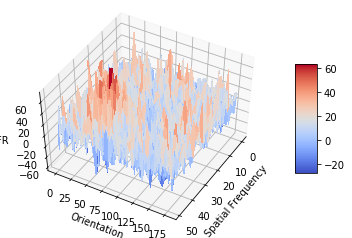

In [25]:
# Now let's take a look at the resulting network activity, just for the first layer to get an idea
# This represents the 'firing rate' of a particular neuron with a particular tuning preference in response to a
# particular stimulus. 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.arange(levels)
Y = np.linspace(0,180,levels)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X,Y,FR[:,:,1],cmap=cm.coolwarm,linewidth=0,antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Spatial Frequency')
ax.set_ylabel('Orientation')
ax.set_zlabel('FR')
ax.view_init(50, 30)

# What happens if you change the input stimulus?  Move it around (change orientation or spatial frequency) 
# to see what happens.


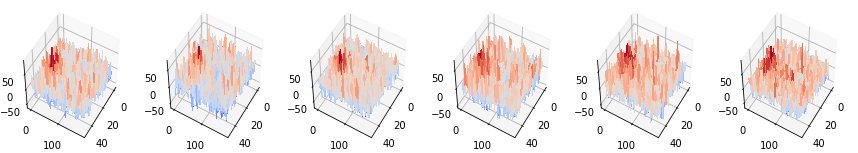

In [26]:
# Plot the slight change in the 'hill' of activity for a few layers of neurons, just to look at it.
# It won't look like much difference.  But you can play around with the noise amount and it will look 
# more and more different, if you want to.
# This could represent the difference in firing rate, due to random noise, across units with the exact same tuning
# preferences.  It could also represent the difference in firing rate of the *same* units across trials of an
# experiment, given the same stimulus input.  See below for more.

plt.figure(figsize=(15, 4))
for i in range(0,6):
    ax = plt.subplot(1,6,i+1,projection='3d',adjustable='box', aspect=.3)
    surf = ax.plot_surface(X,Y,FR[:,:,i],cmap=cm.coolwarm,linewidth=0,antialiased=False)
    ax.view_init(50, 30)   
    



In [27]:
# Next, we could either read these out directly (mimicking single-cell electrophysiology), or we could build 
# 'voxels' that could be read out with fMRI and, ultimately, MVPA.

# How do we build voxels?
# The easiest way would be to assume that voxels have dimensions n x n x n, such that it divides evenly into the
# number of neurons we have overall.  Because we set up our 'cortical space' to be topographically organized, this
# is a reasonable assumption.

voxsize = [2,2,2]

# Let's then assume that each voxel simply averages the activity of the neurons inside it in order to produce a BOLD
# signal. 
BOLD = np.zeros((levels/voxsize[0],levels/voxsize[1],levels/voxsize[2]))
for v1 in range(0,levels,voxsize[0]):
    for v2 in range(0,levels,voxsize[1]):
        for v3 in range(0,nunits,voxsize[2]):
            BOLD[v1/2,v2/2,v3/2] = np.mean(FR[v1:(v1+voxsize[0]),v2:(v2+voxsize[1]),v3:(v3+voxsize[2])])



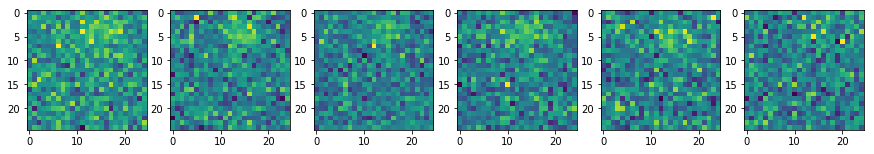

In [10]:
# Let's take a look at what that BOLD pattern might look like in a few 'slices' of cortex, just as we did above,
# or across trials of an experiment, depending on what your 3rd dimension represents.
X = np.arange(levels/voxsize[0])
Y = np.arange(levels/voxsize[1])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(15, 4))
for i in range(0,6):
    ax = plt.subplot(1,6,i+1)
    #plt.subplots()
    plt.imshow(np.asarray(BOLD[:,:,i]),aspect='equal')

            
# See the 'hill' of activity around [x=15,y=3]?  If you can't, try playing with the inputs to make it clearer.
# Or you could average across 'trials' or 'layers', or try smoothing, or other tricks we've learned in the course.

In [11]:
# We have now successfully simulated voxels, based on the underlying neural activity in a very simplified but 
# biologically plausible network.  Granted this oversimplified model is just a toy right now, but it's a start to
# get you going.  The next steps are up to you.

# What can you do with simulated voxels?
# One possible next step would be to run an 'experiment' where you 'show' this network a stimulus 1000x or 10,000x.  

# You could then hypothesize about the effects of a particular stimulus manipulation on neural activity, to be read
# out via the BOLD signal.
# Perhaps your manipulation changes the noise in the system, or changes the fano factor.
# Perhaps your manipulation changes the mean location of the 'hill' of activity (e.g. showing a different stimulus).

# Or maybe you have two ROIs, and the activity is correlated across time -- perhaps you hypothesize that your 
# experimental manipulation should increase or decrease this functional connectivity for voxels that have 
# some tuning preferences but not others, as with Decoded Neurofeedback (DecNef; Shibata et al., 2011).  You could
# simulate 2 networks to do this, but link them together.

# Correlated activity (noise correlations) could also be measured within an ROI, via making the network a bit more
# biologically plausible.  You could add lateral inhibition and/or recurrent excitation to your neural network, 
# like center-surround inhibition for example, or inhibition/excitation based on tuning preferences.
# Then you could see how changes in overall inhibition levels (e.g., because of different concentrations of GABA, 
# which have been shown in normal vs. schizophrenic populations) might predict different BOLD patterns.
# Or how changes in excitatory/inhibitory connections as a function of perceptual learning impact sharpening of
# tuning functions, as read out by fMRI.

# You could take this principle and apply it not to a rate-averaged network, as we've built here, but a spiking
# 'integrate-and-fire' network.  If you go all the way down to very low-level simulated neurons in a network, you
# could hypothesize about how synaptic plasticity or changes in channel concentrations would affect not just the
# neural activity, but the BOLD signal.

# What else could you do with a generative model?
# Classification of different conditions? Of different populations of subjects? 
# RSA?
# Basically, once you have a generative model with some degree of biological plausibility (depending on what level you
# care about), the possibilities are nearly endless.

